##IMPORTING LIBRARIES

In [125]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import sklearn 
%matplotlib inline

Importing Data

In [127]:
pd.set_option('display.max_columns',None)
data_cust = pd.read_csv('client_data.csv')
data_prices = pd.read_csv('price_data.csv')

Exploring Data

In [128]:
#having a look at the data
data_cust.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [129]:
#conversion of the dates to datetime format
data_cust['date_activ']= pd.to_datetime(data_cust['date_activ'])
data_cust['date_end']= pd.to_datetime(data_cust['date_end'])
data_cust['date_renewal']= pd.to_datetime(data_cust['date_renewal'])
data_cust['date_modif_prod']= pd.to_datetime(data_cust['date_modif_prod'])
data_prices['price_date']= pd.to_datetime(data_prices['price_date'])

#Feature Engineering

In [130]:
#creating a new column contract length
data_cust['contract_length']=((data_cust['date_end']-data_cust['date_activ'])/np.timedelta64(1,'M')).astype(int)

In [131]:
#now lets create more features from the date columns in the data
ref_time=pd.to_datetime('2016-01-01')
#creating a funtion to calculate the months from reference time
def month_cal(reference_time,DF,column):
    time_diff=reference_time-DF[column]
    months=(time_diff/np.timedelta64(1,'M')).astype(int)
    return months

In [132]:
#Getting the month values
data_cust['month_from_activation']=month_cal(ref_time,data_cust,'date_activ')
data_cust['month_from_end']=month_cal(ref_time,data_cust,'date_end')
data_cust['month_from_renewal']=month_cal(ref_time,data_cust,'date_renewal')
data_cust['month_from_prod_modif']=month_cal(ref_time,data_cust,'date_modif_prod')

In [133]:
#now that we have created a more usefull feature we can let go of the other date columns
data_cust=data_cust.drop(columns=['date_activ','date_end','date_renewal','date_modif_prod'])

In [134]:
# Group off-peak prices by companies and month
monthly_price_by_id = data_prices.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [135]:
#merging the year price difference to the main dataframe 
data_cust_new=pd.merge(diff,data_cust[['churn','id']], on='id')

In [136]:
#creating a dataframe with mean_year prices against ids 
mean_year=data_prices.groupby(['id']).mean().reset_index() 

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\2782324443.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_year=data_prices.groupby(['id']).mean().reset_index()


In [137]:
#creating a dataframe with mean_6_month_prices prices against ids
mean_past_6m=data_prices[data_prices['price_date']>'2015-06-01'].groupby(['id']).mean().reset_index()

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\3601039770.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_past_6m=data_prices[data_prices['price_date']>'2015-06-01'].groupby(['id']).mean().reset_index()


In [138]:
#creating a dataframe with mean_3_month_prices prices against ids
mean_past_3m=data_prices[data_prices['price_date']>'2015-09-01'].groupby(['id']).mean().reset_index()

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\4120365921.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_past_3m=data_prices[data_prices['price_date']>'2015-09-01'].groupby(['id']).mean().reset_index()


In [139]:
#new mean year price frame
mean_year=mean_year.rename(index=str,columns={'price_off_peak_var':'mean_year_price_off_peak_var',
                                              'price_peak_var':'mean_year_price_peak_var',
                                              'price_mid_peak_var':'mean_year_price_mid_peak_var',
                                              'price_off_peak_fix':'mean_year_price_off_peak_fix',
                                              'price_peak_fix':'mean_year_price_peak_fix',
                                              'price_mid_peak_fix':'mean_year_price_mid_peak_fix'})

mean_year['mean_year_price_off_peak']=mean_year['mean_year_price_off_peak_var']+mean_year['mean_year_price_off_peak_fix']
mean_year['mean_year_price_peak']=mean_year['mean_year_price_peak_var']+mean_year['mean_year_price_peak_fix']
mean_year['mean_year_price_mid_peak']=mean_year['mean_year_price_mid_peak_var']+mean_year['mean_year_price_mid_peak_fix']

In [140]:
#new past 6m average prices frame
mean_past_6m=mean_past_6m.rename(index=str,columns={'price_off_peak_var':'mean_6m_price_off_peak_var',
                                              'price_peak_var':'mean_6m_price_peak_var',
                                              'price_mid_peak_var':'mean_6m_price_mid_peak_var',
                                              'price_off_peak_fix':'mean_6m_price_off_peak_fix',
                                              'price_peak_fix':'mean_6m_price_peak_fix',
                                              'price_mid_peak_fix':'mean_6m_price_mid_peak_fix'})

mean_past_6m['mean_6m_price_off_peak']=mean_past_6m['mean_6m_price_off_peak_var']+mean_past_6m['mean_6m_price_off_peak_fix']
mean_past_6m['mean_6m_price_peak']=mean_past_6m['mean_6m_price_peak_var']+mean_past_6m['mean_6m_price_peak_fix']
mean_past_6m['mean_6m_price_mid_peak']=mean_past_6m['mean_6m_price_mid_peak_var']+mean_past_6m['mean_6m_price_mid_peak_fix']

In [141]:
#new past 3 month average price dataframe
mean_past_3m=mean_past_3m.rename(index=str,columns={'price_off_peak_var':'mean_3m_price_off_peak_var',
                                              'price_peak_var':'mean_3m_price_peak_var',
                                              'price_mid_peak_var':'mean_3m_price_mid_peak_var',
                                              'price_off_peak_fix':'mean_3m_price_off_peak_fix',
                                              'price_peak_fix':'mean_3m_price_peak_fix',
                                              'price_mid_peak_fix':'mean_3m_price_mid_peak_fix'})

mean_past_3m['mean_3m_price_off_peak']=mean_past_3m['mean_3m_price_off_peak_var']+mean_past_3m['mean_3m_price_off_peak_fix']
mean_past_3m['mean_3m_price_peak']=mean_past_3m['mean_3m_price_peak_var']+mean_past_3m['mean_3m_price_peak_fix']
mean_past_3m['mean_3m_price_mid_peak']=mean_past_3m['mean_3m_price_mid_peak_var']+mean_past_3m['mean_3m_price_mid_peak_fix']

In [142]:
#creating a new dataframe with all the price details
data_price_new=pd.merge(mean_year,mean_past_6m, on='id',how='left')
data_price_new=pd.merge(data_price_new,mean_past_6m, on='id',how='left')
data_price_new=pd.merge(data_price_new,diff,on='id',how='left')
data_price_new

,id,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_mid_peak,mean_6m_price_off_peak_var_x,mean_6m_price_peak_var_x,mean_6m_price_mid_peak_var_x,mean_6m_price_off_peak_fix_x,mean_6m_price_peak_fix_x,mean_6m_price_mid_peak_fix_x,mean_6m_price_off_peak_x,mean_6m_price_peak_x,mean_6m_price_mid_peak_x,mean_6m_price_off_peak_var_y,mean_6m_price_peak_var_y,mean_6m_price_mid_peak_var_y,mean_6m_price_off_peak_fix_y,mean_6m_price_peak_fix_y,mean_6m_price_mid_peak_fix_y,mean_6m_price_off_peak_y,mean_6m_price_peak_y,mean_6m_price_mid_peak_y,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,40.826071,24.524832,16.353854,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,0.121266,0.102368,0.073728,40.728885,24.437330,16.291555,40.850151,24.539698,16.365283,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,44.531877,0.000000,0.000000,0.144687,0.000000,0.000000,44.444710,0.000000,0.000000,44.589397,0.000000,0.000000,0.144687,0.000000,0.000000,44.444710,0.000000,0.000000,44.589397,0.000000,0.000000,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,45.501268,0.000000,0.000000,0.202024,0.000000,0.000000,45.944710,0.000000,0.000000,46.146734,0.000000,0.000000,0.202024,0.000000,0.000000,45.944710,0.000000,0.000000,46.146734,0.000000,0.000000,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,40.766185,24.486748,16.328003,0.114428,0.096080,0.069418,40.728885,24.437330,16.291555,40.843313,24.533410,16.360973,0.114428,0.096080,0.069418,40.728885,24.437330,16.291555,40.843313,24.533410,16.360973,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,44.414856,0.000000,0.000000,0.146184,0.000000,0.000000,44.266930,0.000000,0.000000,44.413114,0.000000,0.000000,0.146184,0.000000,0.000000,44.266930,0.000000,0.000000,44.413114,0.000000,0.000000,-0.003994,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972,41.035291,24.752581,16.588752,0.113848,0.095499,0.068838,40.728885,24.437330,16.291555,40.842733,24.532829,16.360393,0.113848,0.095499,0.068838,40.728885,24.437330,16.291555,40.842733,24.532829,16.360393,-0.050232,-0.335085
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000,44.458512,0.000000,0.000000,0.145449,0.000000,0.000000,44.355820,0.000000,0.000000,44.501269,0.000000,0.000000,0.145449,0.000000,0.000000,44.355820,0.000000,0.000000,44.501269,0.000000,0.000000,-0.003778,0.177779
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569,41.314049,25.025265,16.858411,0.152759,0.127566,0.091403,41.228885,24.937330,16.791555,41.381645,25.064896,16.882958,0.152759,0.127566,0.091403,41.228885,24.937330,16.791555,41.381645,25.064896,16.882958,-0.001760,0.164916
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678,40.730558,24.467516,16.316414,0.120150,0.101570,0.073983,40.647429,24.388454,16.258969,40.767579,24.490024,16.332952,0.120150,0.101570,0.073983,40.647429,24.388454,16.258969,40.767579,24.490024,16.332952,-0.009391,0.162916


In [143]:
#getting mode of the following feature for missing value imputation
z=str(data_cust['channel_sales'].mode()[0])
y=str(data_cust['origin_up'].mode()[0])

In [144]:
#imputing mode for missing value and renaming the values
data_cust['channel_sales']=data_cust['channel_sales'].apply(lambda x : z if x=='MISSING' else x)
data_cust['origin_up']=data_cust['origin_up'].apply(lambda x : y if x=='MISSING' else x)
data_cust['channel_sales']=data_cust['channel_sales'].apply(lambda x : x[:4])
data_cust['origin_up']=data_cust['origin_up'].apply(lambda x : x[:4])

#Feature Encoding

In [145]:
#enconding variable has gas
data_cust['has_gas']=data_cust['has_gas'].replace(['t','f'],[1,0])

In [146]:
#encoding variables
cat_channel=pd.get_dummies(data_cust[['channel_sales']])
cat_origin=pd.get_dummies(data_cust[['origin_up']])
data_cust.drop(columns=['channel_sales','origin_up'],inplace=True)

In [147]:
#Use the common index to merge 
data_cust=pd.merge(data_cust,cat_channel,left_index=True,right_index=True)
data_cust=pd.merge(data_cust,cat_origin,left_index=True,right_index=True)

In [148]:
#merging the price and customer data in one dataframe
data_cust=pd.merge(data_cust,data_price_new, on='id', how='left')

##Tranforming Numerical Data

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\2385419812.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cust['log_cons_12m']);


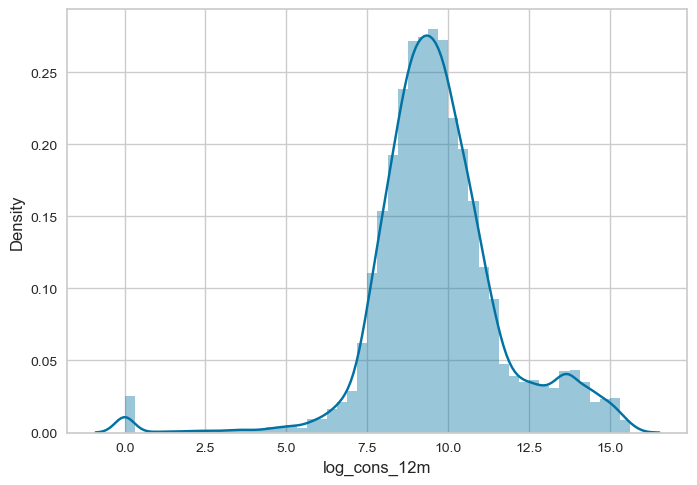

In [149]:
#First for the cons_12, remove the negative values and apply a log tranformation
data_cust['log_cons_12m']=data_cust['cons_12m'].apply(lambda x:np.log(1+x))
sns.distplot(data_cust['log_cons_12m']);

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\3799891175.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cust['log_cons_gas_12m']);


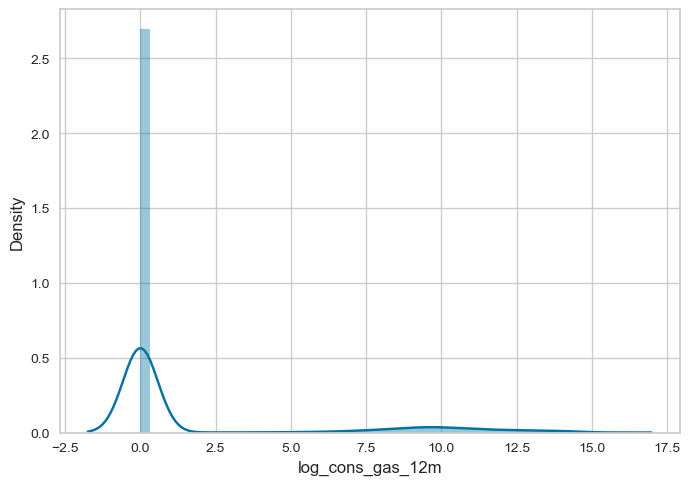

In [150]:
#First for the cons_gas_12, remove the negative values and apply a log tranformation
data_cust['log_cons_gas_12m']=data_cust['cons_gas_12m'].apply(lambda x:np.log(1+x))
sns.distplot(data_cust['log_cons_gas_12m']);

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\153437920.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cust['cons_last_month']);


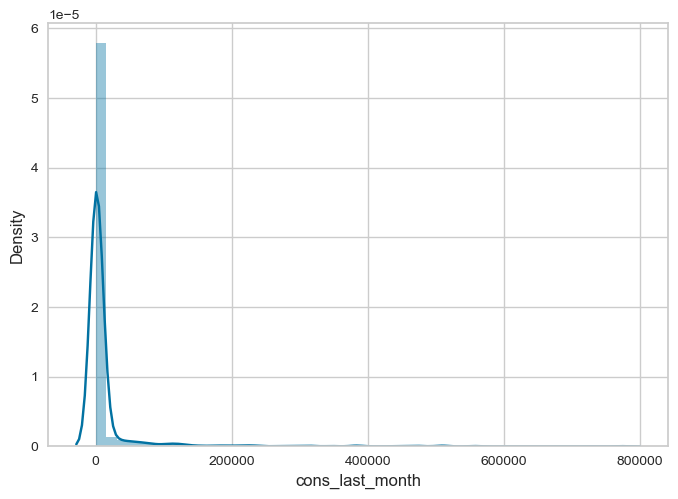

In [151]:
#First for the cons_gas_12, remove the negative values and apply a log tranformation
data_cust['log_cons_last_month']=data_cust['cons_last_month'].apply(lambda x:np.log(1+x))
sns.distplot(data_cust['cons_last_month']);

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\399406501.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cust['log_forecast_cons_12m']);


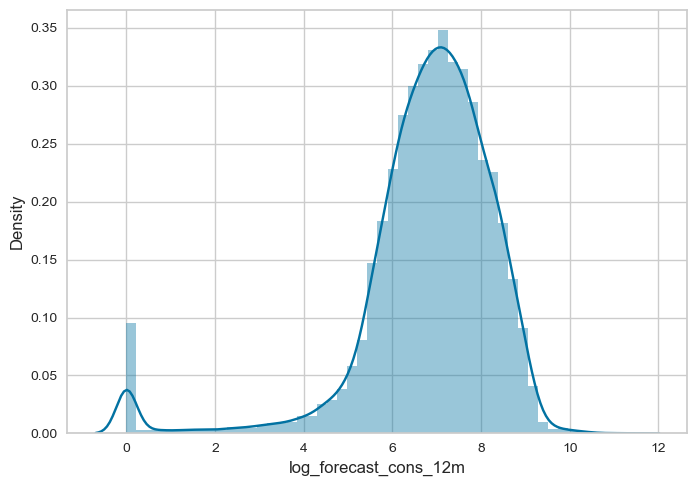

In [152]:
#log transformation on forecast_cons_12m 
data_cust['log_forecast_cons_12m']=data_cust['forecast_cons_12m'].apply(lambda x:np.log(1+x))
sns.distplot(data_cust['log_forecast_cons_12m']);

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\218417417.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cust['log_forecast_cons_year']);


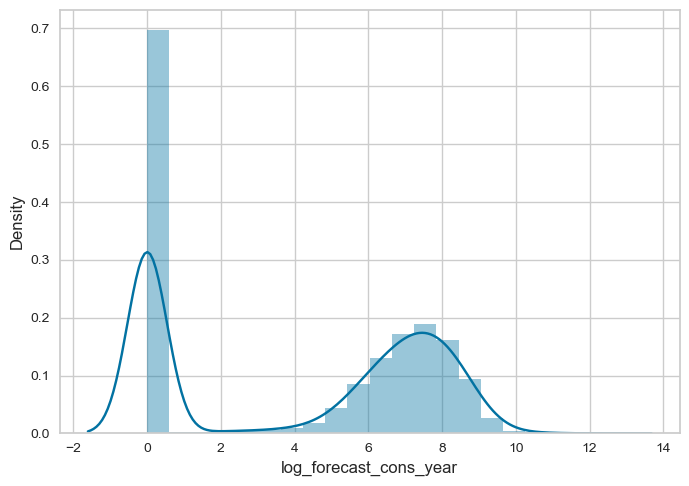

In [153]:
#log transformation on forecast_cons_year 
data_cust['log_forecast_cons_year']=data_cust['forecast_cons_year'].apply(lambda x:np.log(1+x))
sns.distplot(data_cust['log_forecast_cons_year']);

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\1877024726.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cust['log_forecast_meter_rent_12m']);


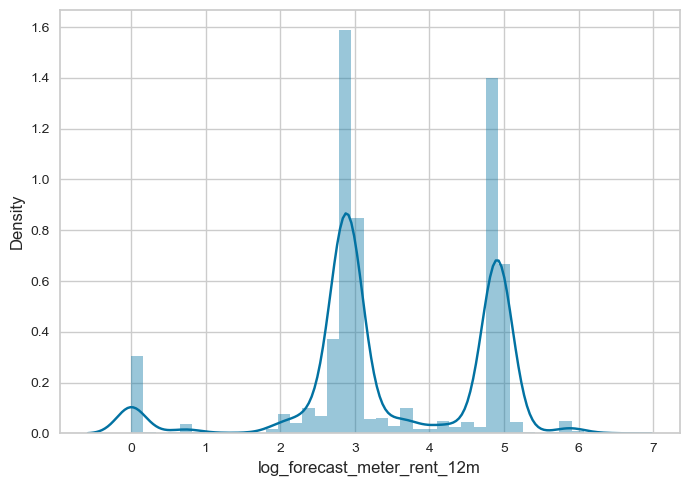

In [154]:
#log transformation on forecast_meter_rent_12m 
data_cust['log_forecast_meter_rent_12m']=data_cust['forecast_meter_rent_12m'].apply(lambda x:np.log(1+x))
sns.distplot(data_cust['log_forecast_meter_rent_12m']);

C:\Users\jubin\AppData\Local\Temp\ipykernel_8016\320363494.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cust['log_imp_cons']);


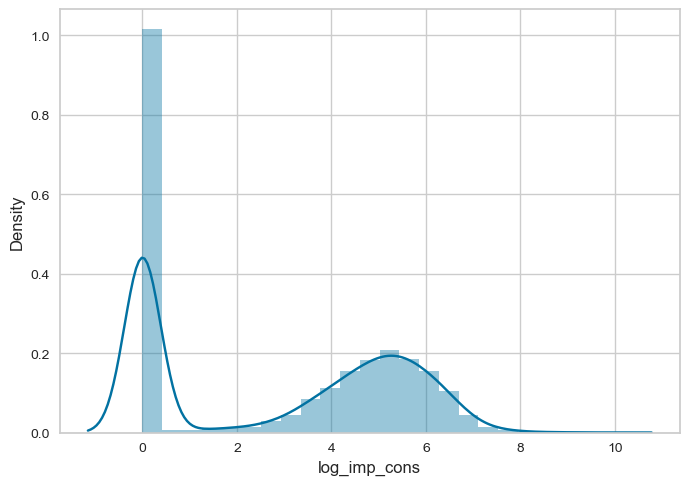

In [155]:
#log transformation on imp_cons
data_cust['log_imp_cons']=data_cust['imp_cons'].apply(lambda x:np.log(1+x))
sns.distplot(data_cust['log_imp_cons']);

In [156]:
#droping the previously transformed features
data_cust.drop(columns=['cons_12m','cons_gas_12m','cons_last_month',
                'forecast_cons_12m','forecast_cons_year', 
                'forecast_meter_rent_12m','imp_cons'],inplace=True)

In [157]:
#definition of a function for removal of outliers and first detection of them based on the upper and lower qnatiles
def remove_outliers(df,col):
    df.loc[df[col]<0,col]=df[col].mean()
    q1=df[col].quantile(.25)
    q3=df[col].quantile(.75)
    iqr=q3-q1
    upper_bound=q3+(iqr*1.5)
    lower_bound=q1-(iqr*1.5)
    df=df[(lower_bound<df[col])|(df[col]<upper_bound)]

In [158]:
#outlier removal 
remove_outliers(data_cust,'log_cons_12m')
remove_outliers(data_cust,'log_cons_gas_12m')
remove_outliers(data_cust,'log_cons_last_month')
remove_outliers(data_cust,'log_forecast_cons_12m')
remove_outliers(data_cust,'log_forecast_meter_rent_12m')
remove_outliers(data_cust,'log_forecast_cons_year')
remove_outliers(data_cust,'log_imp_cons')
remove_outliers(data_cust,'forecast_discount_energy')
remove_outliers(data_cust,'margin_gross_pow_ele')
remove_outliers(data_cust,'margin_net_pow_ele')
remove_outliers(data_cust,'net_margin')
remove_outliers(data_cust,'pow_max')

In [159]:
#creating the feature and label set
data_cust.drop(columns=['id'],inplace=True)
X=data_cust.drop(columns=['churn'])
y=data_cust['churn']

In [171]:
#since our data was imbalance we need to create and synthesize more values for churn =1
#or else our results will naturally be having fitting issues
# using imblearn for removing imablance in our dataset with respect to booking_complete=1
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
print(X_smote.shape)
print(y_smote.shape)

(26374, 64)
(26374,)


In [175]:
#splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_smote,y_smote,test_size=.25,random_state=0)

In [176]:
#calling RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [184]:
#model RFC after creating the fit
model=rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

In [197]:
#classification report 
from sklearn.metrics import classification_report
report=classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3294
           1       0.98      0.92      0.95      3300

    accuracy                           0.95      6594
   macro avg       0.95      0.95      0.95      6594
weighted avg       0.95      0.95      0.95      6594



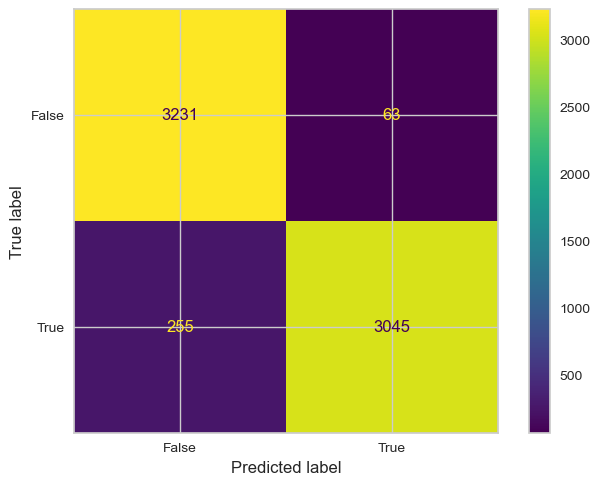

In [186]:
#drawing confusion matrix
from sklearn.metrics import confusion_matrix
con_mat=confusion_matrix(y_test,y_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = con_mat, display_labels=[False,True])
cm_display.plot()

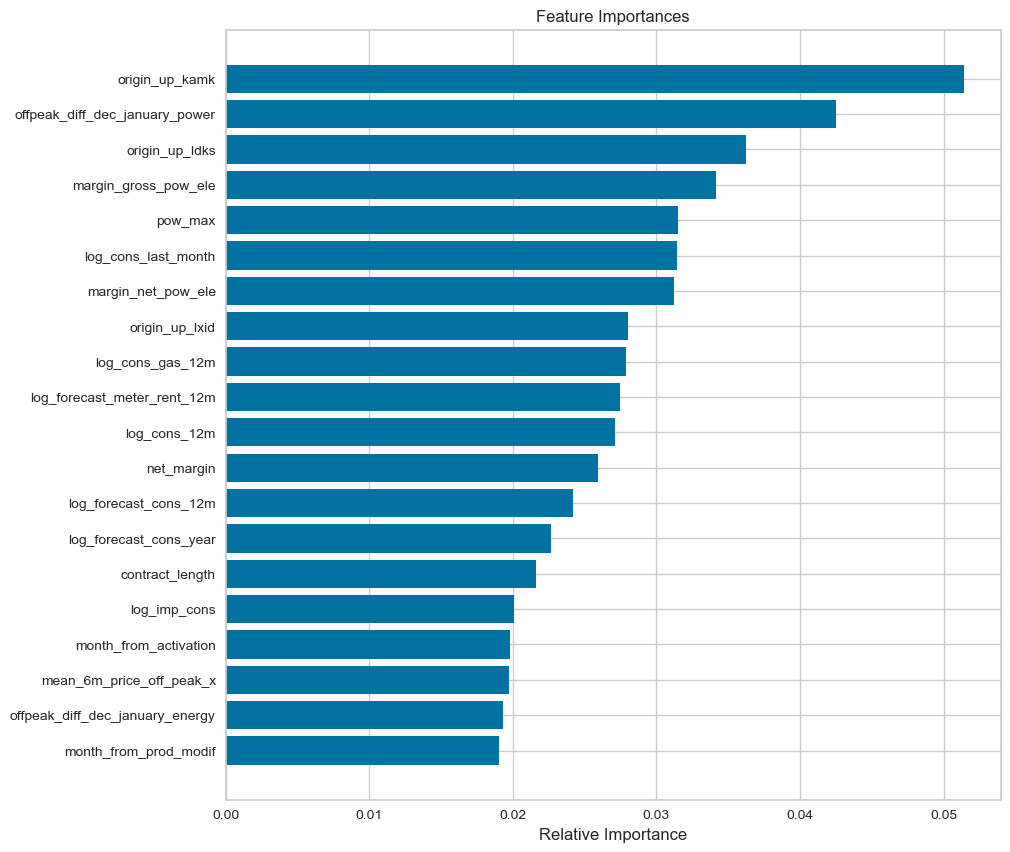

In [195]:
sfeatures = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 20

plt.figure(figsize=(10,10))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

Advantages of RandomForest Algorithm

In [198]:
#Advantages
#can handle data with noise well, can handle outliers as well
#works well for both regression and classification problems
#can handle missing values

#disadvantages
#complex to understand
#take more computational power and time